**Léa ZADIKIAN - Décembre 2022**
# Projet n° 5 : Segmentez des clients d'un site e-commerce
## Notebook n°3 / 3 : Simulation contrat de maintenance

Données et définition des variables : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

## Sommaire :
<a href="#C1">1. Import des librairies</a>

<a href="#C2">2. Contrat de Maintenance </a>

    
    



# <a name="C1">1. Import des librairies</a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans

from sklearn import metrics


# <a name="C2">2. Contrat de maintenance</a>
L'objectif est de pouvoir fournir à Olist une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance. 
Pour analyser la stabilité des segments au cours du temps, nous allons effectuer des simulations pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation fin que celui-ci reste pertinent.

In [2]:
#Lecture et affichage du fichier 'olist_model_1' (modèle RFM )
rfm_rs=pd.read_csv('olist_model_2.csv')
rfm_rs

,customer_unique_id,Recency,Frequency,Monetary,Review Score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4.0
2,0000f46a3911fa3c0805444483337064,537,1,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,5.0
...,...,...,...,...,...
92588,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42,5.0
92589,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58,4.0
92590,ffff371b4d645b6ecea244b27531430a,568,1,112.46,5.0
92591,ffff5962728ec6157033ef9805bacc48,119,1,133.69,5.0


In [3]:
X = rfm_rs.drop(columns='customer_unique_id')# X : df comportant les 4 features RFM + Review Score
X.describe()

,Recency,Frequency,Monetary,Review Score
count,92593.000000,92593.000000,92593.000000,92593.000000
mean,237.672459,1.032810,164.930911,4.152873
std,152.612419,0.207907,225.121680,1.280820
min,1.000000,1.000000,0.000000,1.000000
25%,114.000000,1.000000,63.000000,4.000000
50%,219.000000,1.000000,107.780000,5.000000
75%,346.000000,1.000000,182.290000,5.000000
max,714.000000,15.000000,13664.080000,5.000000


In [4]:
def normalize_data(df):
    """Cette fonction permet de normaliser les données avec passage au log des variables et StandardScaler de sklearn.

Parameters
        ----------
        df : pd.DataFrame, 
            pandas DataFrame du jeu de données d'apprentissage à transformer.
       
        Returns
        -------
        df_normalized, pd.DataFrame,
           Renvoie le DataFrame normalisé.
    """
    
    cols = df.columns.tolist()
        
    df_normalized = df[cols].copy()
    
    # Passage au log
    df_normalized[cols] = df_normalized[cols].applymap(lambda x : 1 if x <= 0 else x)
    df_normalized[cols] = df_normalized[cols].apply(np.log,axis=1).round(3)

    # Standardisation des données avec StandarScaler
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(df_normalized[cols])
    
    df_normalized[cols] = X_scaled
  
    return df_normalized

In [5]:
def stability_cluster_one_year(dataframe,
                               col_data,
                               n_cluster=4,
                               recence_col="R"):
    """Cette fonction permet de calculer la stabilité du clustering dans le temps (sur 1 an). Cette fonction utilise 
    l'algorithme de K-Means. Le scoring est effectué avec l'ARI (Adjuster Random Index) qui compare par paire 
    les similarités entre 2 clusterings (avec un score de 1 pour une ressemblance parfaite et un score négatif pour des clusters totalement différents). 
    
        Parameters
        ----------
        dataframe : pd.DataFrame, 
            pandas DataFrame du jeu de données d'apprentissage (non normalisé).
            
        col_data : list, 
            Liste des noms de colonnes.
            
        Optional
        ----------
            
        n_cluster : int, default=4,
            Indique le nombre de cluster choisi pour l'algorithme du K-Means.
            
        recence_col : str, default='R'
            Indique le nom de la colonne de correspondant à la récence 'R' de 'RFM'
            
    
        Returns
        -------
        df_result, pd.DataFrame,
           Renvoie un DataFrame contenant les résultats.
    """
    
    
    all_freq_update = range(0,390,30) # périodicité de test 1 à 12 mois

    last_train = 360 # Période de temps prise en compte pour le modèle initial : 1 an

    max_sample = dataframe[(dataframe[recence_col] <= last_train) & \
                             (dataframe[recence_col] > last_train - all_freq_update[0])].shape[0] 
    
    # Initialisation d'un tableau vide pour stocker les scores ARI
    score_ari = []

    # Dataframe sur la pétiode initial
    before = dataframe[dataframe[recence_col] > last_train]
    X_train = before[col_data]

    # Normalisation du df
    X_train = normalize_data(X_train)

    # Entraînement du K-Means sur la période le dataframe de la période initiale
    kmeans_before = KMeans(n_clusters=n_cluster)
    kmeans_before.fit(X_train)

    # Boucle sur les périodes de temps 1 à 12 mois
    for freq in all_freq_update:
        
        after = dataframe[(dataframe[recence_col] > last_train - freq)] # df des données sur la nouvelle période : période initiale + période supplémentaire
        X_test = after[col_data]
        X_test = normalize_data(X_test)
        
        # Prédiction du K-Means sur les nouvelles données à partir du modèle entraîné sur la période initiale.
        y_true=kmeans_before.predict(X_test)
        
        # K-Means sur la nouvelle période
        kmeans_after = KMeans(n_clusters=n_cluster)
        kmeans_after.fit(X_test)
        y_pred=kmeans_after.predict(X_test)
        
        # Calcul du score ARI pour comparer des 2 clusterings
        score_ari.append(metrics.adjusted_rand_score(y_true,y_pred))
        
        
    # Représentation graphique du score ARI en fonction du temps   
    plt.figure(figsize=(9,7))
    plt.title("Stabilité des clusters dans le temps")
    plt.plot(range(0,13),score_ari)
    plt.xlabel("Nombre de mois")
    plt.ylabel("Score ARI")
    plt.grid(True)
    plt.show()
        
    return pd.DataFrame([
       ["0 mois", "1 mois","2 mois","3 mois","4 mois","5 mois","6 mois","7 mois"," 8 mois","9 mois","10 mois","11 mois","1 an"],
        score_ari],
        index=["Fréquence","Score ARI"]).T



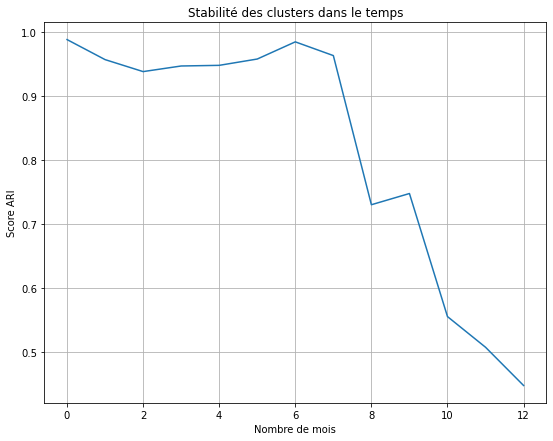

,Fréquence,Score ARI
0,0 mois,0.987983
1,1 mois,0.956697
2,2 mois,0.937977
3,3 mois,0.946738
4,4 mois,0.947739
5,5 mois,0.957608
6,6 mois,0.984427
7,7 mois,0.962976
8,8 mois,0.730085
9,9 mois,0.74759


In [6]:
stability_cluster_one_year(rfm_rs,['Recency','Frequency','Monetary'],n_cluster=4,recence_col='Recency')

A partir de  7 mois, on observe une cassure au niveau de la courbe représentant le score ARI. Il baisse nettement entre 7 et 8 mois. On peut donc recommander une maintenance de la segmentation 2 fois par an.